In [1]:
import glob
import os


import numpy as np
import nibabel as nib

import matplotlib.pyplot as plt

In [2]:
la_cine  = nib.load('../../MnM-2/training/001/001_LA_CINE.nii.gz').get_fdata()

la_ed = nib.load('../../MnM-2/training/001/001_LA_ED.nii.gz').get_fdata()
la_ed_gt = nib.load('../../MnM-2/training/001/001_LA_ED_gt.nii.gz').get_fdata()

la_es = nib.load('../../MnM-2/training/001/001_LA_ES.nii.gz').get_fdata()
la_es_gt = nib.load('../../MnM-2/training/001/001_LA_ES_gt.nii.gz').get_fdata()

In [3]:
la_cine.shape, \
la_ed.shape, \
la_ed_gt.shape

((256, 256, 1, 25), (256, 256, 1), (256, 256, 1))

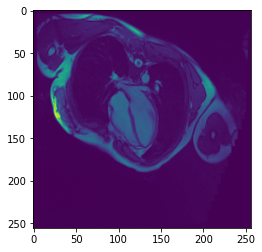

In [4]:
plt.imshow(la_cine[:, :, 0, 24])

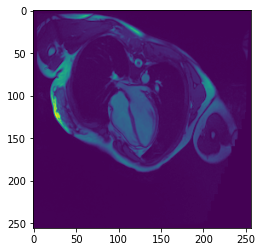

In [5]:
plt.imshow(la_ed[:, :, 0])

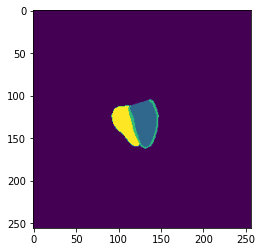

In [6]:
plt.imshow(la_ed_gt[:, :, 0])

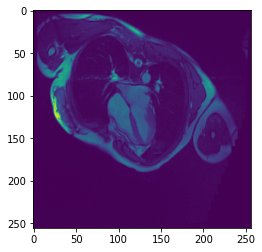

In [7]:
plt.imshow(la_es[:, :, 0])

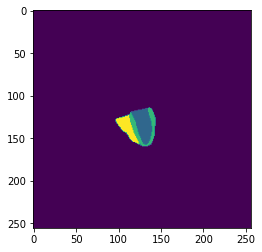

In [8]:
plt.imshow(la_es_gt[:, :, 0])

In [9]:
np.unique(la_ed_gt)

array([0., 1., 2., 3.])